<a href="https://colab.research.google.com/github/chrischo11/Quant-Investment/blob/main/Nasdaq_ETF_inv_startegy_backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import statsmodels.api as sm

In [ ]:
df = pd.read_csv('QQQ.csv', parse_dates=[0], index_col=[0])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-03-10,51.12500,51.156250,50.28125,51.0625,44.011379,5232000
1999-03-11,51.43750,51.734375,50.31250,51.3125,44.226860,9688600
1999-03-12,51.12500,51.156250,49.65625,50.0625,43.149452,8743600
1999-03-15,50.43750,51.562500,49.90625,51.5000,44.388477,6369000
1999-03-16,51.71875,52.156250,51.15625,51.9375,44.765553,4905800


In [ ]:
# Faber's market timing
df['ret'] = df['Adj Close'].pct_change()

df['10MA'] = df['Adj Close'].rolling(220).mean()

df['lag_Diff'] = df['Adj Close'].shift() - df['10MA'].shift() # 전일자의 조정종가와, 전일까지의 10개월 이동평균값 비교해서 차이를 가지고 다음날 거래

df = df[['High', 'Low', 'Close', 'Adj Close', '10MA', 'ret', 'lag_Diff']]

df.iloc[210:225]

,High,Low,Close,Adj Close,10MA,ret,lag_Diff
Date,,,,,,,
2000-01-06,88.000000,79.750000,80.09375,69.033737,NaN,-0.068678,NaN
2000-01-07,90.000000,82.500000,90.00000,77.572052,NaN,0.123683,NaN
2000-01-10,93.937500,89.937500,92.50000,79.726830,NaN,0.027778,NaN
2000-01-11,92.875000,87.000000,88.00000,75.848221,NaN,-0.048649,NaN
2000-01-12,89.242188,86.000000,86.06250,74.178307,NaN,-0.022017,NaN
2000-01-13,91.500000,87.078125,91.25000,78.649445,NaN,0.060276,NaN
2000-01-14,93.625000,92.000000,93.37500,80.481056,NaN,0.023288,NaN
2000-01-18,94.437500,91.437500,93.87500,80.911972,NaN,0.005354,NaN
2000-01-19,96.000000,92.429688,96.00000,82.743530,NaN,0.022636,NaN


In [ ]:
df['fab_weight'] = 0
df['fab_weight'].loc[df['lag_Diff'] > 0] = 1

df['fab_ret'] = df['ret'] * df['fab_weight']

<ipython-input-780-ba2e57236ef3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Managed vol

df['ret2'] = df['ret']**2 # squared return for volatility prediction
df['rangevar'] = ((df['High'] - df['Low'])/ df['Close'].shift()) ** 2 / 2.39
df['rangevar_MA10day'] = df['rangevar'].rolling(10).mean() # 10일간의 range variance SMA
df = df.dropna()
df['vol_pred'] =np.nan
# df = df.loc['2021-06-02':]  # 언제부터 투자한 것으로 볼지 입력해주기

## Decide the day of first investment

In [ ]:
df = df.loc['2018-01-02':'2020-06-30']

In [ ]:
for t in range(120, len(df)-1):
    regdata = df.iloc[(t-120):t] # 120개의 일자를 가지고 서브셋 데이터프레임 만들고
    Y       = regdata['ret2'].iloc[1:] # 그 서브셋에서 다시 두번째 열부터 해서 ret2 로 데이터 프레임
    X       = regdata[['rangevar', 'rangevar_MA10day', 'ret']].shift().iloc[1:] # 그 서브셋의 래그 값을 두번째 열부터 입력
    # 전일의 레인지 var, 10일 이동평균, return 변수로 당일의 변동성 ret2와의 관계를 설명하는 모델
    # 120일의 데이터를 가지고 training해서 모델을 만든다.
    res     = sm.OLS(Y, sm.add_constant(X)).fit()
    Xt      = regdata[['rangevar', 'rangevar_MA10day', 'ret']].iloc[119]
    
    # 121번째 일짜부터 vol 예측치를 입력해준다. 회귀분석모델에서 도출한 efficient number를 통해 
    df['vol_pred'].iloc[t+1] = (res.params[0] + (res.params[1:] * Xt).sum()) ** 0.5

df['mv_weight'] = 0.01 / df['vol_pred'] # 어제자 vol prediction으로 weight 결정해야하므로 
df['mv_ret'] = df['mv_weight'] * df['ret']
    

<ipython-input-783-731534a2fda0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-783-731534a2fda0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-783-731534a2fda0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-783-731534a2fda0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

In [ ]:
# managed vol_simple

# df['lagvol20'] = df['ret'].rolling(20).std().shift()
# df['mv_weight'] = 0.01 / df['lagvol20']
# df['mv_ret'] = df['ret'] * df['mv_weight']

In [ ]:
df['cum_ret'] = (1+df['ret']).cumprod()
df['money_cumret'] = 100*df['cum_ret']
df['cum_fabret'] = (1+df['fab_ret']).cumprod()
df['money_cumfabret'] = 100*df['cum_fabret']
df['cum_mvret'] = (1+df['mv_ret']).cumprod()
df['money_cummvret'] = 100*df['cum_mvret']

In [ ]:
df.loc['2020-03-01':'2020-03-30']

,High,Low,Close,Adj Close,10MA,ret,lag_Diff,fab_weight,fab_ret,ret2,...,rangevar_MA10day,vol_pred,mv_weight,mv_ret,cum_ret,money_cumret,cum_fabret,money_cumfabret,cum_mvret,money_cummvret
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-02,216.570007,205.940002,216.419998,213.105270,193.970373,0.051603,8.816824,1,0.051603,2.662902e-03,...,0.000451,0.035526,0.281487,0.014526,1.412732,141.273233,1.164920,116.491956,1.275359,127.535949
2020-03-03,219.610001,207.619995,209.479996,206.271591,194.075653,-0.032067,19.134897,1,-0.032067,1.028302e-03,...,0.000576,0.025844,0.386939,-0.012408,1.367430,136.743003,1.127564,112.756390,1.259535,125.953478
2020-03-04,218.330002,211.369995,218.220001,214.877731,194.218984,0.041722,12.195938,1,0.041722,1.740756e-03,...,0.000620,0.044158,0.226461,0.009449,1.424482,142.448245,1.174609,117.460854,1.271435,127.143550
2020-03-05,216.360001,210.100006,211.589996,208.349243,194.330284,-0.030382,20.658747,1,-0.030382,9.230865e-04,...,0.000636,0.047057,0.212509,-0.006457,1.381203,138.120335,1.138921,113.892119,1.263226,126.322644
2020-03-06,209.149994,202.910004,208.020004,204.833923,194.414975,-0.016872,14.018959,1,-0.016872,2.846727e-04,...,0.000655,0.046683,0.214208,-0.003614,1.357899,135.789934,1.119705,111.970503,1.258661,125.866091
2020-03-09,201.160004,192.110001,193.570007,190.605270,194.437659,-0.069464,10.418948,1,-0.069464,4.825294e-03,...,0.000722,0.039840,0.251006,-0.017436,1.263574,126.357376,1.041925,104.192546,1.236715,123.671497
2020-03-10,204.300003,193.679993,204.110001,200.983826,194.504095,0.054451,-3.832389,0,0.000000,2.964859e-03,...,0.000775,0.030264,0.330422,0.017992,1.332376,133.237601,1.041925,104.192546,1.258965,125.896550
2020-03-11,200.750000,192.729996,195.220001,192.229980,194.529983,-0.043555,6.479731,1,-0.043555,1.897036e-03,...,0.000813,0.051261,0.195081,-0.008497,1.274344,127.434440,0.996544,99.654442,1.248268,124.826840
2020-03-12,190.779999,176.940002,177.320007,174.604141,194.474109,-0.091691,-2.300003,0,-0.000000,8.407316e-03,...,0.000917,0.047794,0.209232,-0.019185,1.157498,115.749796,0.996544,99.654442,1.224321,122.432060


In [ ]:
stats = df[['ret', 'fab_ret', 'mv_ret']].describe()

stats.loc['Sharpe'] = stats.loc['mean'] / stats.loc['std'] * np.sqrt(264)
stats.loc['annual_ret'] = stats.loc['mean'] * 264

stats.loc[['mean','std','Sharpe','annual_ret']]

,ret,fab_ret,mv_ret
mean,0.000912,0.000407,0.000776
std,0.016756,0.012132,0.010928
Sharpe,0.884445,0.544806,1.153827
annual_ret,0.240785,0.107393,0.204879


In [ ]:
df.tail(1)[['money_cumret', 'money_cumfabret', 'money_cummvret']] # 100 투자했을 때 현재 가치

,money_cumret,money_cumfabret,money_cummvret
Date,,,
2020-06-30,162.252815,123.235512,142.840731


In [ ]:
# df[['cum_ret', 'cum_fabret', 'cum_mvret']].plot()

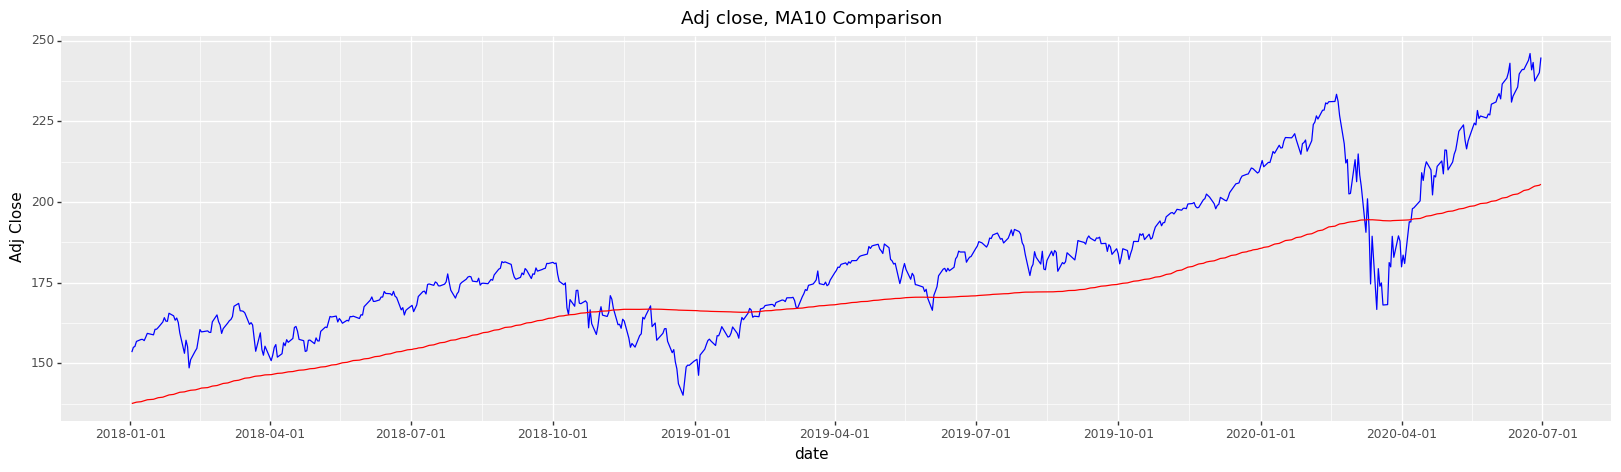

<ggplot: (125921257750)>

In [ ]:
(
   ggplot(df, aes('df.index')) + 
   geom_line(aes(y = 'Adj Close'), color='blue') + 
   geom_line(aes(y = '10MA'), color = 'red') +
   labs(y = "Adj Close", title ="Adj close, MA10 Comparison", x= "date") +
   theme(figure_size=(20,5))
) 

In [ ]:
# sd = df[['ret', 'mv_ret']].dropna().rolling(264).std()
# sd.plot()

c:\Users\HOME\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 21 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 142 rows containing missing values.


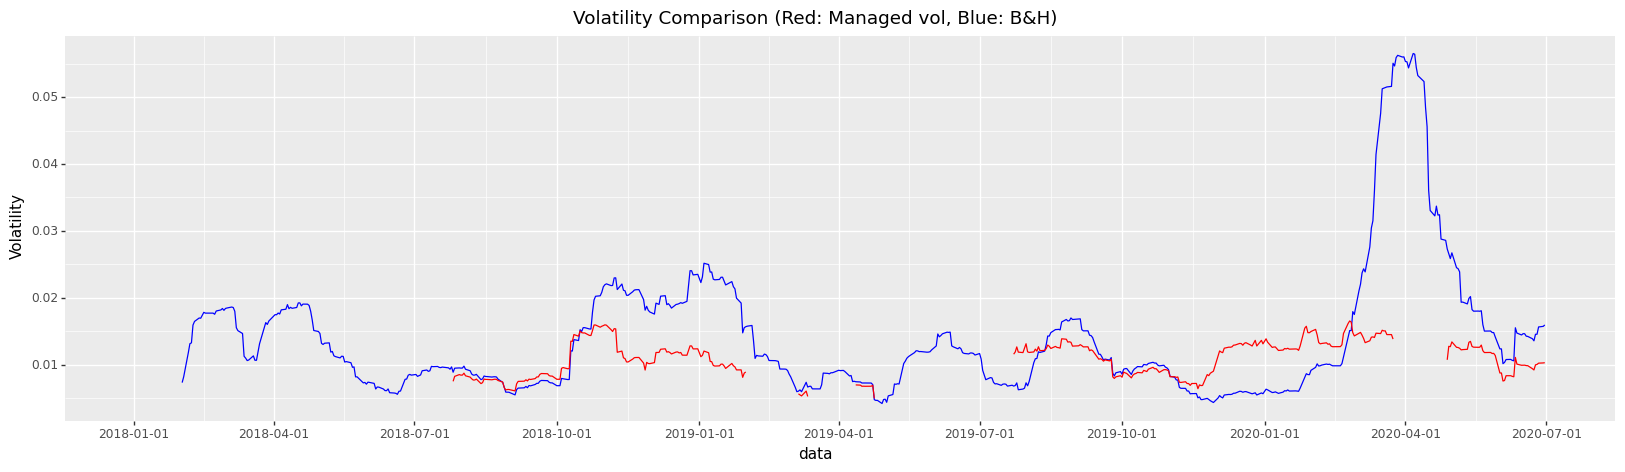

<ggplot: (125917560290)>

In [ ]:
(
   ggplot(df, aes('df.index')) + 
   geom_line(aes(y = df['ret'].rolling(22).std()), color='blue') + 
   geom_line(aes(y = df['mv_ret'].rolling(22).std()), color = 'red') +
   labs(y = "Volatility", title ="Volatility Comparison (Red: Managed vol, Blue: B&H)", x="data") +
   theme(figure_size=(20,5))
) 

c:\Users\HOME\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 121 rows containing missing values.


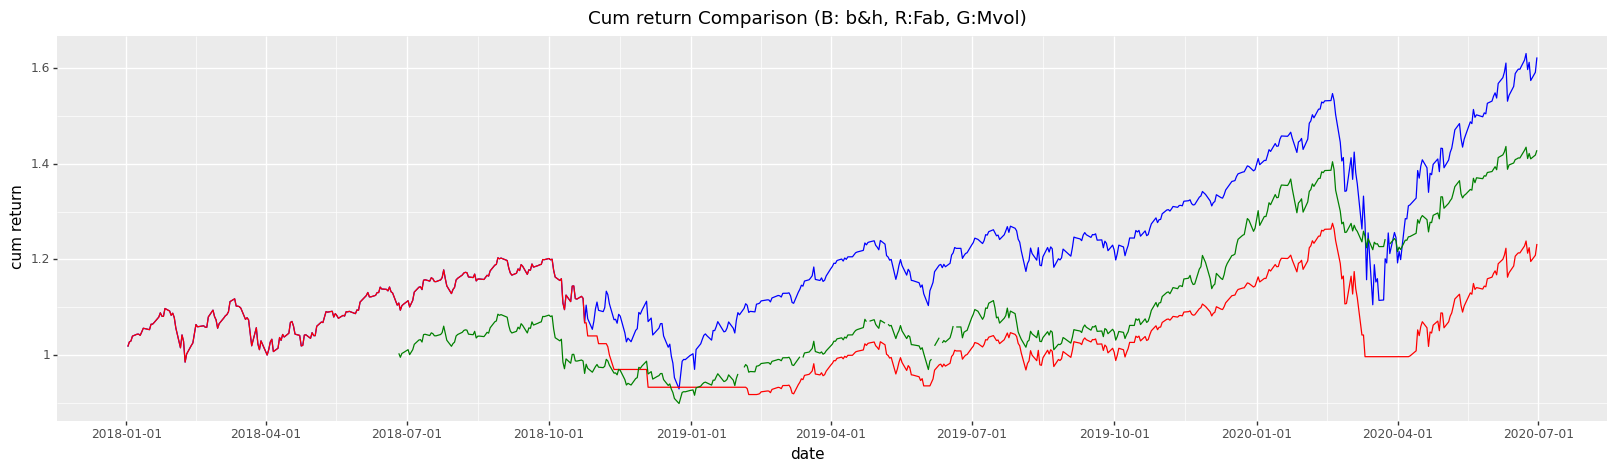

<ggplot: (125916984387)>

In [ ]:

(
   ggplot(df, aes('df.index')) + 
   geom_line(aes(y = 'cum_ret'), color='blue') + 
   geom_line(aes(y = 'cum_fabret'), color = 'red') +
   geom_line(aes(y = 'cum_mvret'), color = 'green') +
   labs(y = "cum return", title ="Cum return Comparison (B: b&h, R:Fab, G:Mvol)", x="date") +
   theme(figure_size=(20,5))
) 

In [ ]:
df.loc['2022-01-01':].head(20)

,High,Low,Close,Adj Close,10MA,ret,lag_Diff,fab_weight,fab_ret,ret2,...,rangevar_MA10day,vol_pred,mv_weight,mv_ret,cum_ret,money_cumret,cum_fabret,money_cumfabret,cum_mvret,money_cummvret
Date,,,,,,,,,,,,,,,,,,,,,
